Generating Gap Analysis Heatmap...


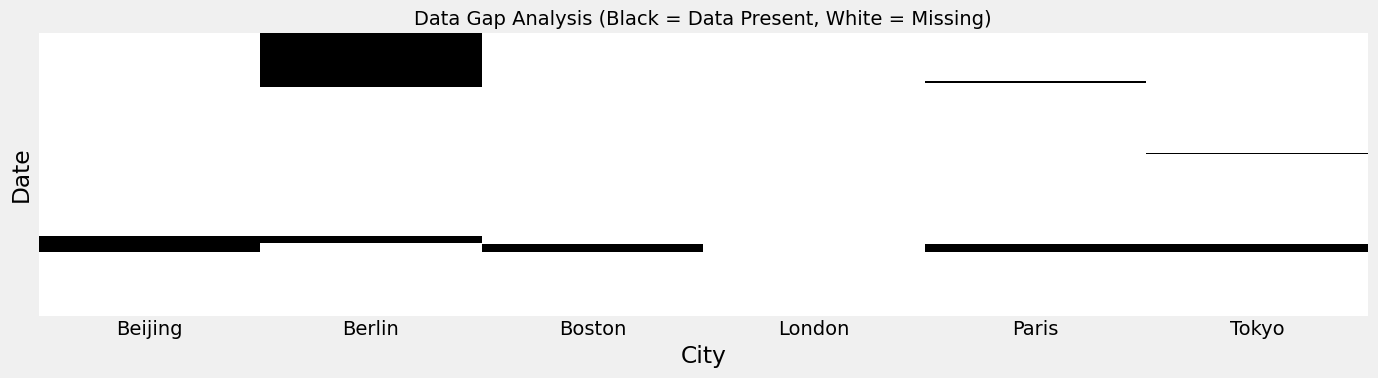

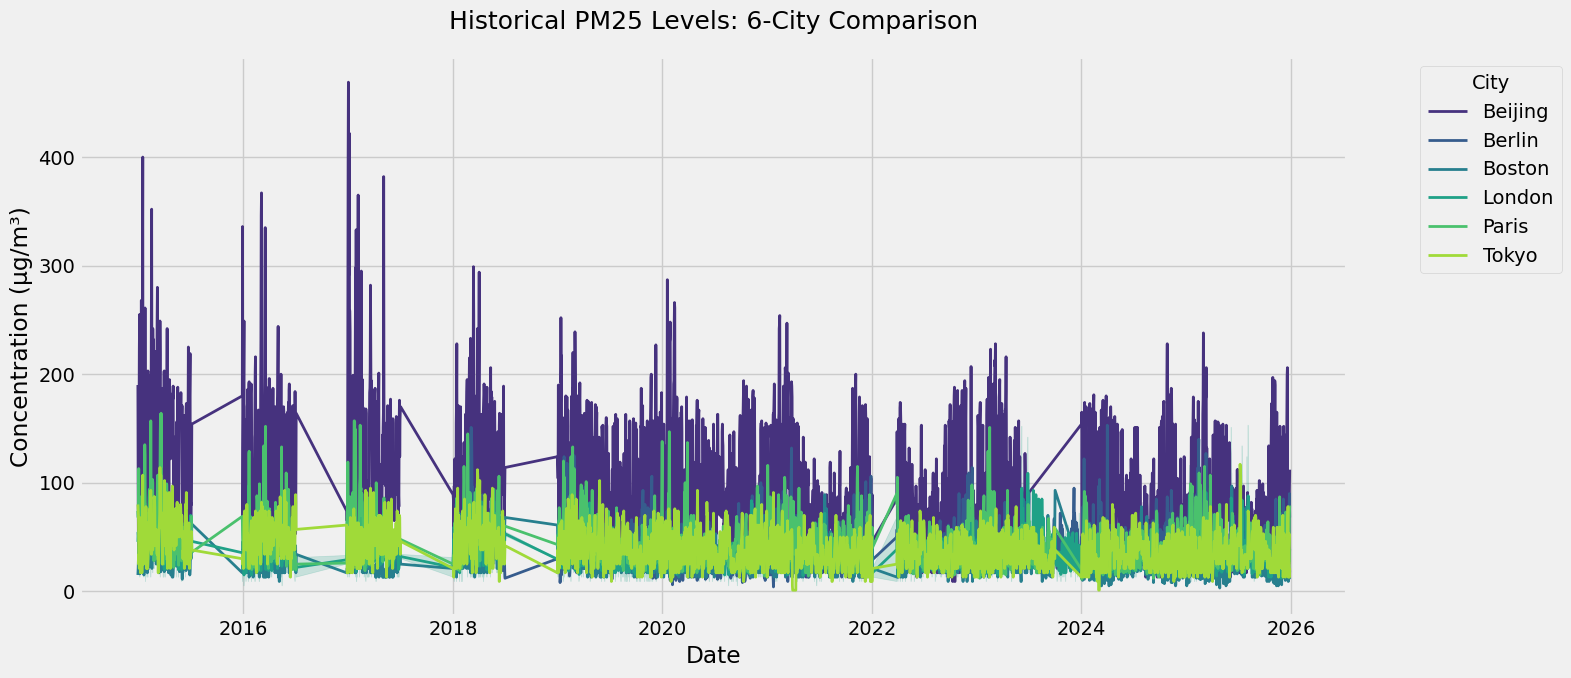

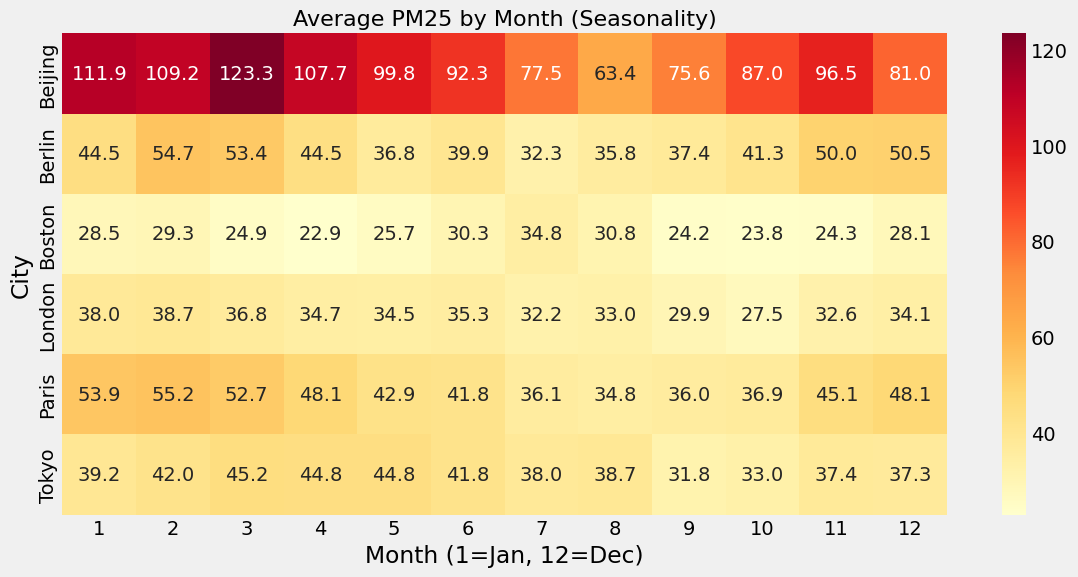

C:\Users\klevi\AppData\Local\Temp\ipykernel_13476\154747052.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=plot_df, x='City', y='median', inner="quart", palette='muted')


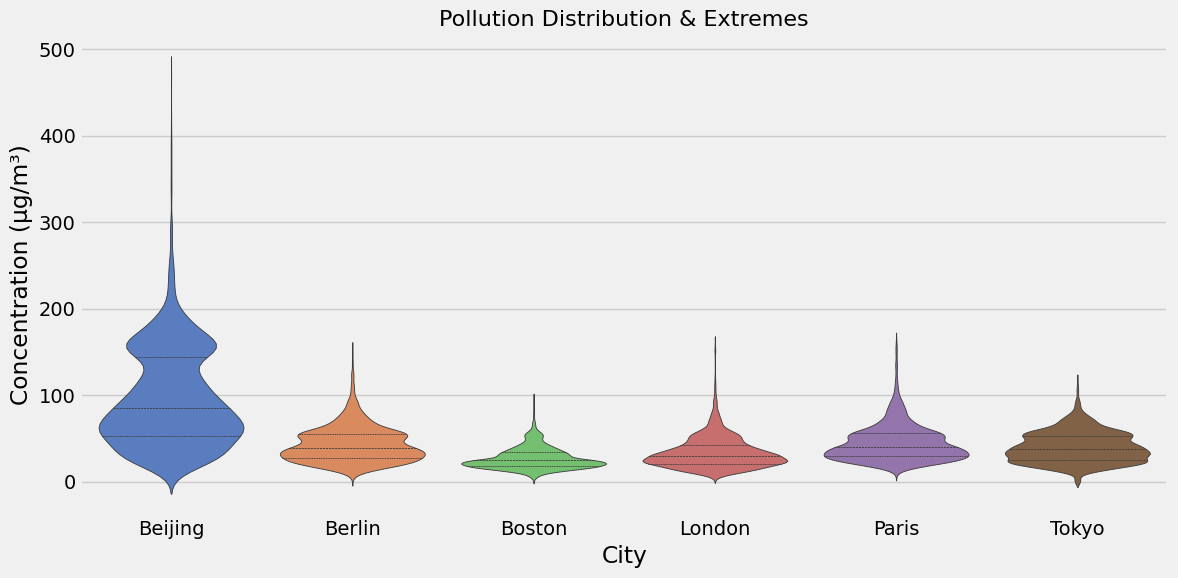


Resampling data to Daily frequency to make it Forecast-Ready...

--- DONE ---
1. Forecast-ready data saved to: c:\Users\klevi\Desktop\Time Series Analysis\Air_Quality_Index-CAPSTONE_PROJECT\data\processed\forecast_ready.parquet
2. All visualizations saved to: c:\Users\klevi\Desktop\Time Series Analysis\Air_Quality_Index-CAPSTONE_PROJECT\outputs
Total Daily records generated: 22955


In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- CONFIGURATION ---
# Assumes notebook is in 'notebooks' folder. 
BASE_DIR = os.path.dirname(os.getcwd()) 
INPUT_FILE = os.path.join(BASE_DIR, "data", "processed", "filtered_data.parquet")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set professional visualization style
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

# 1. LOAD PROCESSED DATA
df = pd.read_parquet(INPUT_FILE)
df['Date'] = pd.to_datetime(df['Date'])

# Filter strictly for PM2.5 for the analysis and forecast
target_specie = 'pm25'
plot_df = df[df['Specie'] == target_specie].copy()

# 2. GAP ANALYSIS (Visualizing missing data holes)
print("Generating Gap Analysis Heatmap...")
pivot_check = plot_df.pivot_table(index='Date', columns='City', values='median')

plt.figure(figsize=(14, 4))
sns.heatmap(pivot_check.isnull(), cbar=False, yticklabels=False, cmap='binary')
plt.title('Data Gap Analysis (Black = Data Present, White = Missing)', fontsize=14)
plt.tight_layout()
plt.show()

# 3. HISTORICAL TRENDS CHART
plt.figure(figsize=(16, 7))
sns.lineplot(data=plot_df, x='Date', y='median', hue='City', linewidth=2)
plt.title(f'Historical {target_specie.upper()} Levels: 6-City Comparison', fontsize=18, pad=20)
plt.ylabel('Concentration (µg/m³)')
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "overall_trends.png"))
plt.show()

# 4. SEASONALITY HEATMAP
plot_df['Month'] = plot_df['Date'].dt.month
pivot_df = plot_df.groupby(['City', 'Month'])['median'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt=".1f")
plt.title(f'Average {target_specie.upper()} by Month (Seasonality)', fontsize=16)
plt.xlabel('Month (1=Jan, 12=Dec)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "seasonal_heatmap.png"))
plt.show()

# 5. DISTRIBUTION & VOLATILITY (Violin Plot)
plt.figure(figsize=(12, 6))
sns.violinplot(data=plot_df, x='City', y='median', inner="quart", palette='muted')
plt.title(f'Pollution Distribution & Extremes', fontsize=16)
plt.ylabel('Concentration (µg/m³)')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "city_volatility.png"))
plt.show()

# 6. MAKE FORECAST READY (Daily Resampling)
# This is the most important part for forecasting: 
# It creates a continuous daily timeline for each city.
print("\nResampling data to Daily frequency to make it Forecast-Ready...")

# Sort and set index for resampling
plot_df = plot_df.sort_values(['City', 'Date'])
forecast_ready = (
    plot_df.set_index('Date')
    .groupby('City')['median']
    .resample('D')
    .mean()
    .reset_index()
)

# Save the final file that you will use in your Forecasting Notebook
FORECAST_FILE = os.path.join(BASE_DIR, "data", "processed", "forecast_ready.parquet")
forecast_ready.to_parquet(FORECAST_FILE, index=False)

print(f"\n--- DONE ---")
print(f"1. Forecast-ready data saved to: {FORECAST_FILE}")
print(f"2. All visualizations saved to: {OUTPUT_DIR}")
print(f"Total Daily records generated: {len(forecast_ready)}")